In [17]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import seaborn as sns 
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve


In [18]:
from google.colab import drive
drive.mount("/content/gdrive")
train = pd.read_csv('/content/gdrive/My Drive/Cisc_452_Neural_Network/covid_dataset/Corona_NLP_train.csv',encoding='latin-1')
test = pd.read_csv('/content/gdrive/My Drive/Cisc_452_Neural_Network/covid_dataset/Corona_NLP_test.csv',encoding='latin-1')

# Combaine train and test set
df = train.append(test, ignore_index=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [20]:
#Encode categorical feature 
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 4 #2
    elif sentiment == "Extremely Negative":
        return 3 #0
    elif sentiment == "Positive":
        return 2 #2
    elif sentiment == "Negative":
        return 1 #0
    else:
        return 0 #1

2    12369
1    10958
0     8332
4     7223
3     6073
Name: Sentiment, dtype: int64
**********************************************************************


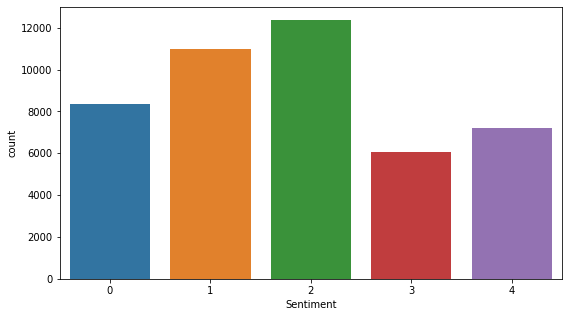

In [21]:
# Apply convert_Sentiment function
df.Sentiment = df.Sentiment.apply(lambda x : convert_Sentiment(x))
# Visualize Sentiment
print(df.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Sentiment',data = df)
plt.show()

In [22]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",3


In [23]:
# Data cleaning
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [24]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [25]:
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

In [26]:
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

In [27]:
def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

In [28]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,menyrbie phil gahan chrisitv and and,0
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths to give elder...,2
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,2
4,3803,48755,NaN,16-03-2020,me ready to go at supermarket during the covid...,3


In [29]:
 #Split sentiment groups 
'''Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet'''
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 0].OriginalTweet
Negative = df[df['Sentiment'] == 1].OriginalTweet
Extreamly_Positive = df[df['Sentiment'] == 4].OriginalTweet
Extreamly_Negative = df[df['Sentiment'] == 3].OriginalTweet


In [30]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,menyrbie phil gahan chrisitv and and,0
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths to give elder...,2
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,2
4,3803,48755,NaN,16-03-2020,me ready to go at supermarket during the covid...,3


In [31]:
X = df['OriginalTweet']
y = df['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (35964,)
Shape of y_train :  (35964,)
Shape of X_test :  (8991,)
Shape of y_test :  (8991,)


In [32]:
# Convert y to categorical 
'''y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)'''
y_train = to_categorical(y_train, 5)
y_test  = to_categorical(y_test, 5)
# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
#print(list_tokenized_train[0])
#print(list_tokenized_test[0])

In [33]:
# convert tokenized texts into same padding size
maxlen = 100
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)
# Create Model 
from keras.layers import SpatialDropout1D 
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
#x   =  SpatialDropout1D(0.3)(x)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x) #60 to 256
#x   =  LSTM(60, name='lstm_layer',dropout = 0.2, recurrent_dropout = 0.2)(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(5, activation="softmax")(x)

In [34]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
r = model.fit(X_train_final,y_train, epochs=3,validation_split=0.2)#validation_data=(X_test_final,y_test)

Epoch 1/3
900/900 [==============================] - 90s 97ms/step - loss: 1.0911 - accuracy: 0.5508 - val_loss: 0.7498 - val_accuracy: 0.7349
Epoch 2/3
900/900 [==============================] - 85s 95ms/step - loss: 0.6251 - accuracy: 0.7803 - val_loss: 0.6621 - val_accuracy: 0.7657
Epoch 3/3
900/900 [==============================] - 86s 95ms/step - loss: 0.4355 - accuracy: 0.8550 - val_loss: 0.6720 - val_accuracy: 0.7644


[]

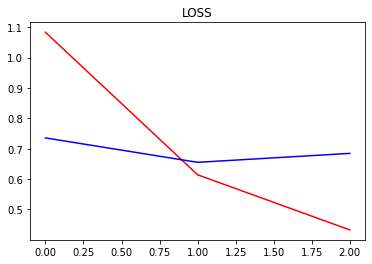

In [ ]:
plt.plot(r.history['loss'],color = 'red')
plt.plot(r.history['val_loss'],color = 'blue')
plt.title('LOSS')
plt.plot()

In [36]:
# Evaluate
model.evaluate(X_test_final,y_test)

281/281 [==============================] - 5s 18ms/step - loss: 0.6850 - accuracy: 0.7608


[0.6849543452262878, 0.7607607841491699]

In [ ]:
# Predict test
lstm_pred = np.round(model.predict(X_test_final))
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)



281/281 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1683
           1       0.70      0.71      0.71      2202
           2       0.72      0.77      0.74      2426
           3       0.86      0.67      0.75      1264
           4       0.79      0.83      0.81      1416

   micro avg       0.78      0.75      0.76      8991
   macro avg       0.80      0.75      0.77      8991
weighted avg       0.78      0.75      0.76      8991
 samples avg       0.75      0.75      0.75      8991



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


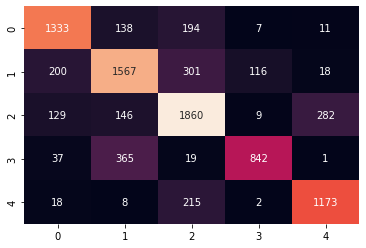

In [ ]:
# confution matrix
confmat = confusion_matrix(y_test.argmax(axis=1),lstm_pred.argmax(axis=1))
#confmat
sns.heatmap(confmat, annot=True, fmt='g', cbar=False)
plt.show()

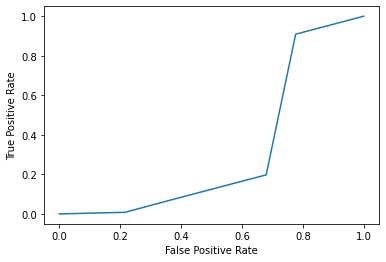

In [ ]:
# Roc curve
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob,pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test.argmax(axis=1),lstm_pred.argmax(axis=1))